# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural com Transformers</font>

## <font color='blue'>Projeto 1</font>
## <font color='blue'>Construindo Um Modelo Transformer Para Previsão de Sequências</font>

https://arxiv.org/pdf/1706.03762.pdf

![DSA](imagens/P1.png)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# https://pypi.org/project/torch/
!pip install -q torch==1.13.1

In [4]:
# Imports
import math
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib: 3.5.2
torch     : 1.13.1
numpy     : 1.22.2



## Geração de Sequências de Dados

Para este projeto vamos criar um conjunto de dados fictícios que usaremos para treinar nosso modelo. Esses dados serão compostos por sequências como:

- 1, 1, 1, 1, 1, 1, 1, 1 → 1, 1, 1, 1, 1, 1, 1, 1


- 0, 0, 0, 0, 0, 0, 0, 0 → 0, 0, 0, 0, 0, 0, 0, 0


- 1, 0, 1, 0, 1, 0, 1, 0 → 1, 0, 1, 0, 1, 0, 1, 0


- 0, 1, 0, 1, 0, 1, 0, 1 → 0, 1, 0, 1, 0, 1, 0, 1


Sinta-se à vontade para alterar a sequência de entrada com seus próprios dados.

O tensor de destino que fornecemos como entrada para o transformador deve ser deslocado em um para a direita (em comparação com o tensor de saída de destino). 

Em outras palavras, o tensor que queremos dar ao modelo para treinamento deve ter um elemento a mais no início e um elemento a menos no final, e o tensor com o qual calculamos a função de perda deve ser deslocado na outra direção. Isso ocorre para que, se dermos um elemento ao modelo durante a inferência, ele nos forneça o próximo (a sequência).

![DSA](imagens/fig1.png)

In [6]:
# Função para gerar dados
def gera_dados(n):
    
    # Array do token de início
    SOS_token = np.array([2])
    
    # Array do token de término
    EOS_token = np.array([3])
    
    # Comrimento da sequência
    length = 8

    # Lista para os dados
    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        
        X = np.zeros(length)
        
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data

In [7]:
# Dados de treino com 9 mil sequências
dados_treino = gera_dados(9000)

In [8]:
# Dados de validação com 3 mil sequências
dados_valid = gera_dados(3000)

## Criando os Batches de Dados

In [9]:
# Função para gerar os batches de dados
def gera_lotes(data, batch_size = 16):
    
    # Lista de batches
    batches = []
    
    # Loop
    for idx in range(0, len(data), batch_size):
        
        # Cria os batches de dados de tamanho 16
        if idx + batch_size < len(data):
            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches de tamanho {batch_size}")

    return batches

In [10]:
# Dataloader com lotes de treino
df_treino = gera_lotes(dados_treino)

562 batches de tamanho 16


In [11]:
# Dataloader com lotes de validação
df_valid = gera_lotes(dados_valid)

187 batches de tamanho 16


## Classe PositionalEncoding

Dizer “eu comi uma pizza com abacaxi” não é o mesmo que dizer “um abacaxi comi eu com pizza”. Logo, a ordem das palavras e a posição de cada palavra no texto importa. E como representar isso no modelo Transformer?

Felizmente, temos uma solução: Codificação Posicional (PositionalEncoding). 

Esta é uma forma de “dar importância” aos elementos em função da sua posição. Criamos um vetor para cada elemento representando sua posição em relação a todos os outros elementos da sequência. A codificação posicional segue esta fórmula abaixo.

![DSA](imagens/fig2.png)

In [12]:
# Classe para a codificação posicional
class PositionalEncoding(nn.Module):
    
    # Método construtor
    def __init__(self, dim_model, dropout_p, max_len):
        
        # Método construtor da classe mãe
        super().__init__()

        # Dropout para evitar overffiting
        self.dropout = nn.Dropout(dropout_p)
        
        # Tensor para a codificação posicional
        pos_encoding = torch.zeros(max_len, dim_model)
        
        # Lista de posições
        positions_list = torch.arange(0, max_len, dtype = torch.float).view(-1, 1) 
        
        # Termo de divisão
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Transposta da matriz de codificação posicional
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        
        # Registra o buffer
        self.register_buffer("pos_encoding", pos_encoding)
        
    # Método forward
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Cria a embedding e aplica o dropout
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

## Classe Transformer

Vamos agora criar classe do Transformador.

Para adicionar a codificação posicional, precisamos de uma camada de embedding para que cada elemento em nossas sequências seja convertido em um vetor que possamos manipular. 

Também precisaremos de uma camada linear final para que possamos converter a saída do modelo nas dimensões de nossa saída desejada. 

In [13]:
# Classe Transformer
class Transformer(nn.Module):

    # Construtor
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p):
        
        # Construtor da classe mãe
        super().__init__()

        # Atributos
        self.model_type = "Transformer"
        self.dim_model = dim_model
        
        # Camada embedding
        self.embedding = nn.Embedding(num_tokens, dim_model)

        # Camada posicional
        self.positional_encoder = PositionalEncoding(dim_model = dim_model, 
                                                     dropout_p = dropout_p, 
                                                     max_len = 5000)
        
        # Camada do transformador
        self.transformer = nn.Transformer(d_model = dim_model,
                                          nhead = num_heads,
                                          num_encoder_layers = num_encoder_layers,
                                          num_decoder_layers = num_decoder_layers,
                                          dropout = dropout_p)
        
        # Camada linear
        self.out = nn.Linear(dim_model, num_tokens)
        
    # Método forward
    def forward(self, src, tgt, tgt_mask = None, src_pad_mask = None, tgt_pad_mask = None):
        
        # Src é uma tupla: (batch_size, comprimento da sequência de origem)
        # Tgt é uma tupla: (batch_size, comprimento da sequência destino)

        # Embedding para a entrada (src) e a saída (tgt)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        
        # Camada posicional da entrada (src) e da saída (tgt)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # Poderíamos usar o parâmetro batch_first = True, mas para simplificação
        # permutamos para obter o tamanho (comprimento da sequência, batch_size, dim_model)
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Bloco Transformer 
        transformer_out = self.transformer(src, 
                                           tgt, 
                                           tgt_mask = tgt_mask, 
                                           src_key_padding_mask = src_pad_mask, 
                                           tgt_key_padding_mask = tgt_pad_mask)
        
        # Saída
        out = self.out(transformer_out)
        
        return out
      
    # Método para gerar a máscara de saída
    def get_tgt_mask(self, size) -> torch.tensor:
        
        # Gera uma matriz quadrada onde cada linha permite que uma palavra a mais seja vista
        mask = torch.tril(torch.ones(size, size) == 1) 
        
        # Converte para float
        mask = mask.float()
        
        # Converte zeros em -inf
        mask = mask.masked_fill(mask == 0, float('-inf')) 
        
        # Converte uns para 0
        mask = mask.masked_fill(mask == 1, float(0.0)) 
        
        return mask
    
    # Função para criar o pad da máscara
    # Se matriz = [1,2,3,0,0,0] onde pad_token=0, a máscara de resultado é [False, False, False, True, True, True]
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

Você deve se lembrar que havia um bloco especial na estrutura do modelo Transformer chamado “masked multi-head attention”.

Então... o que é mascaramento? Vamos recapitular rapidamente o que está acontecendo com nossos tensores quando os alimentamos em nosso modelo. 

Primeiro, incorporamos (embedding) e codificamos (codificação posicional) nosso tensor de origem. Em seguida, nosso tensor de origem é codificado em um tensor que alimentamos em nosso decodificador com nosso vetor de destino incorporado e codificado (posicionalmente). Para que nosso modelo aprenda, não podemos apenas mostrar todo o tensor de destino! Isso apenas daria a ele a resposta direta.

A solução para isso é um tensor de máscara. Este tensor é composto por tamanho (comprimento da sequência x comprimento da sequência), pois para cada elemento da sequência, mostramos ao modelo um elemento a mais. 

Essa matriz será adicionada ao nosso vetor alvo, então a matriz será composta por zeros nas posições onde o transformador pode ter acesso aos elementos, e menos infinito onde não pode. Uma explicação ilustrada pode ajudá-lo um pouco mais:

![DSA](imagens/fig3.png)

Tensores são matrizes que podem ser armazenadas em uma GPU, e como são matrizes, todas as dimensões devem ter elementos do mesmo tamanho. Claro, isso não acontecerá ao lidar com tarefas como PLN ou imagens de tamanhos diferentes. Portanto, usamos os chamados “tokens especiais”. Esses tokens permitem que nosso modelo saiba onde está o início da frase (<SOS>), onde está o final da frase (<EOS>) e quais elementos estão lá apenas para preencher o espaço restante para que nossas matrizes tenham o mesmo tamanho de sequência (<PAD>). Esses tokens também devem ser convertidos em seu ID inteiro correspondente (em nosso exemplo, eles serão 2, 3 e 4, respectivamente). Preencher uma sequência é mais ou menos assim:

![DSA](imagens/fig4.png)

## Criação do Modelo

Vamos criar uma instância do nosso modelo, função de perda e otimizador. Usaremos o otimizador Stochastic Gradient Descent, a função CrossEntropyLoss e uma taxa de aprendizado de 0,01. 

In [14]:
# Seleciona o device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
print(device)

cpu


Se o seu computador tiver GPU, verifique se tem Compute Capability superior a 3 e então instale a plataform CUDA (disponível somente para Windows e Linux).

Compute Capability:

https://developer.nvidia.com/cuda-gpus

Instalação CUDA:

https://developer.nvidia.com/cuda-toolkit

In [16]:
# Hiperparâmetros
ntokens = 4
dmodel = 8
nheads = 2
n_encoder_layers = 3
n_decoder_layers = 3
dropout = 0.1
taxa_aprendizado = 0.01

In [17]:
# Modelo
modelo = Transformer(num_tokens = ntokens, 
                     dim_model = dmodel, 
                     num_heads = nheads, 
                     num_encoder_layers = n_encoder_layers, 
                     num_decoder_layers = n_decoder_layers, 
                     dropout_p = dropout).to(device)

In [18]:
# Otimizador
opt = torch.optim.SGD(modelo.parameters(), lr = taxa_aprendizado)

In [19]:
# Função de perda
loss_fn = nn.CrossEntropyLoss()

## Loop de Treinamento

Agora criamos o loop de treinamento.

In [20]:
# Função para o loop de treinamento
def loop_treino(model, opt, loss_fn, dataloader):
    
    # Coloca o modelo em modo de treino
    model.train()
    
    # Variável para o erro total
    total_loss = 0
    
    # Loop
    for batch in dataloader:
        
        # Carrega um batch
        X, y = batch[:, 0], batch[:, 1]
        
        # Colocamos o batch no device (CPU ou GPU)
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Mudamos o tgt em um, então com o <SOS> prevemos o token na pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Obtemos a máscara para mascarar as próximas palavras
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Faz a previsão passando y_input e tgt_mask, além de X
        pred = model(X, y_input, tgt_mask)

        # Permutar pred para ter o tamanho do lote primeiro 
        pred = pred.permute(1, 2, 0)  
        
        # Função de erro
        loss = loss_fn(pred, y_expected)

        # Zera os gradientes
        opt.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Passo de otimização
        opt.step()
    
        # Calcula o erro total
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

## Loop de Validação

Agora criamos o loop de validação.

In [21]:
# Loop de validação
def loop_valid(model, loss_fn, dataloader):
    
    # Coloca o modelo em modo de avaliação
    model.eval()
    
    # Erro total
    total_loss = 0
    
    # Loop pelo dataloader
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Mudamos o tgt em um, então com o <SOS> prevemos o token na pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Obtemos a máscara para mascarar as próximas palavras
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Faz a previsão passando y_input e tgt_mask, além de X
            pred = model(X, y_input, tgt_mask)

            # Permutar pred para ter o tamanho do lote primeiro 
            pred = pred.permute(1, 2, 0)     
            
            # Calcula o erro
            loss = loss_fn(pred, y_expected)
            
            # Armazena o erro total
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

## Treinamento

Aqui definimos uma função para treinar o modelo.

In [22]:
# Função para treinar o modelo
def treina_modelo(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    
    # Listas para armazenar erro em treino e validação
    train_loss_list, validation_loss_list = [], []
    
    print("\nIniciando o Treinamento do Modelo...\n")
    for epoch in range(epochs):
        
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        # Executa o loop de treino e calcula o erro
        train_loss = loop_treino(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        # Executa o loop de validação e calcula o erro
        validation_loss = loop_valid(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Erro em Treino: {train_loss:.4f}")
        print(f"Erro em Validação: {validation_loss:.4f}")
        print()
        
    print("\nTreinamento Concluído!\n")
        
    return train_loss_list, validation_loss_list

In [23]:
%%time
train_loss_list, validation_loss_list = treina_modelo(modelo, opt, loss_fn, df_treino, df_valid, 10)


Iniciando o Treinamento do Modelo...

------------------------- Epoch 1 -------------------------
Erro em Treino: 0.5409
Erro em Validação: 0.3846

------------------------- Epoch 2 -------------------------
Erro em Treino: 0.3776
Erro em Validação: 0.3094

------------------------- Epoch 3 -------------------------
Erro em Treino: 0.3169
Erro em Validação: 0.2351

------------------------- Epoch 4 -------------------------
Erro em Treino: 0.2744
Erro em Validação: 0.2092

------------------------- Epoch 5 -------------------------
Erro em Treino: 0.2528
Erro em Validação: 0.1798

------------------------- Epoch 6 -------------------------
Erro em Treino: 0.2379
Erro em Validação: 0.1638

------------------------- Epoch 7 -------------------------
Erro em Treino: 0.2302
Erro em Validação: 0.1560

------------------------- Epoch 8 -------------------------
Erro em Treino: 0.2216
Erro em Validação: 0.1626

------------------------- Epoch 9 -------------------------
Erro em Treino: 0.216

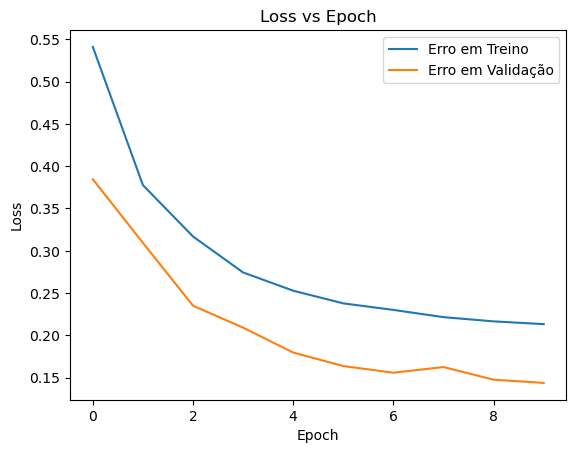

In [24]:
# Plot
plt.plot(train_loss_list, label = "Erro em Treino")
plt.plot(validation_loss_list, label = "Erro em Validação")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

O modelo claramente aprendeu. Hora de usá-lo para fazer previsões.

## Previsões com o Modelo Treinado

Nosso modelo aprendeu a prever o próximo token ao receber um elemento. Portanto, devemos ser capazes de fornecer ao nosso modelo o tensor de entrada e o token inicial, e ele deve nos devolver o próximo elemento. Se, quando o modelo prever um token, nós o concatenarmos com nossa entrada anterior, devemos ser capazes de adicionar lentamente palavras à nossa saída até que nosso modelo preveja o token <EOS>.

In [25]:
# Função para as previsões
def faz_previsoes(model, input_sequence, max_length = 15, SOS_token = 2, EOS_token = 3):
    
    # Coloca o modelo em modo de avaliação
    model.eval()
    
    # Gera y_input
    y_input = torch.tensor([[SOS_token]], dtype = torch.long, device = device)

    # Número de tokens
    num_tokens = len(input_sequence[0])

    # Loop
    for _ in range(max_length):
        
        # Obtém a máscara de origem
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        # Usa o modelo para fazer previsão
        pred = model(input_sequence, y_input, tgt_mask)
        
        # Extrai o valor com mais alta probabilidade
        next_item = pred.topk(1)[1].view(-1)[-1].item() 
        next_item = torch.tensor([[next_item]], device=device)

        # Concatena o input com a melhor previsão
        y_input = torch.cat((y_input, next_item), dim = 1)

        # Para se o modelo previu o fim da sequência
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [26]:
# Novos dados de exemplo (números 2 e 3 são os pads)
novos_dados = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

In [27]:
# Loop para fazer as previsões
for idx, novo_dado in enumerate(novos_dados):
    result = faz_previsoes(modelo, novo_dado)
    print(f"Índice: {idx}")
    print(f"Input: {novo_dado.view(-1).tolist()[1:-1]}")
    print(f"Continuação: {result[1:-1]}")
    print()

Índice: 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuação: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Índice: 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuação: [1, 1, 1, 1, 1, 1, 1, 1, 1]

Índice: 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuação: [1, 0, 1, 0, 1, 0, 1, 0]

Índice: 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuação: [1, 0, 1, 0, 1, 0, 1, 0]

Índice: 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuação: [1, 0, 1, 0, 1, 0, 1, 0]

Índice: 5
Input: [0, 1]
Continuação: [0, 1, 0, 1, 0, 1, 0, 1]



# Fim